# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [ ]:
#!pip install -qU ragas==0.2.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.7/175.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/1

In [ ]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

In [4]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [5]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [6]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [8]:
!mkdir data

mkdir: data: File exists


In [9]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31314    0 31314    0     0  57399      0 --:--:-- --:--:-- --:--:-- 57351


In [10]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70173    0 70173    0     0   131k      0 --:--:-- --:--:-- --:--:--  130k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [11]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.


### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [12]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [13]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [14]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [15]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

KnowledgeGraph(nodes: 14, relationships: 68)

We can save and load our knowledge graphs as follows.

In [16]:
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

KnowledgeGraph(nodes: 14, relationships: 68)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [17]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [18]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.


** Answer: **

- `SingleHopSpecificQuerySynthesizer`: Generates questions that can be answered using a single piece of information or context
- `MultiHopAbstractQuerySynthesizer`: Generates higher-level, conceptual questions that require:
    - Broader understanding
    - Synthesis of information
    - Abstract thinking
    - Generalization across multiple pieces of information
- `MultiHopSpecificQuerySynthesizer`: Generates questions that require connecting multiple pieces of information or facts to arrive at the answer


Finally, we can use our `TestSetGenerator` to generate our testset!

In [19]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating Samples: 100%|██████████| 11/11 [00:38<00:00,  3.53s/it]


,user_input,reference_contexts,reference,synthesizer_name
0,What role has OpenAI played in the development...,[Code may be the best application The ethics o...,"A year ago, OpenAI was the only organization t...",single_hop_specifc_query_synthesizer
1,How does the use of Python relate to the capab...,[Based Development As a computer scientist and...,The grammar rules of programming languages lik...,single_hop_specifc_query_synthesizer
2,What were the significant advancements and cha...,[Simon Willison’s Weblog Subscribe Stuff we fi...,"In 2023, Large Language Models (LLMs) were rec...",single_hop_specifc_query_synthesizer
3,What are the implications of the 'Stable Diffu...,[easy to follow. The rest of the document incl...,The 'Stable Diffusion moment' for large langua...,single_hop_specifc_query_synthesizer
4,what meta do with them LLMs?,[Prompt driven app generation is a commodity a...,"Meta's Llama 3.3 70B model, released in Decemb...",single_hop_specifc_query_synthesizer
5,How has increased competition influenced the u...,[<1-hop>\n\nPrompt driven app generation is a ...,Increased competition in 2024 has significantl...,multi_hop_abstract_query_synthesizer
6,How has increased competition influenced the u...,[<1-hop>\n\nPrompt driven app generation is a ...,Increased competition has significantly influe...,multi_hop_abstract_query_synthesizer
7,How have advancements in large language models...,[<1-hop>\n\nPrompt driven app generation is a ...,"Advancements in large language models, particu...",multi_hop_abstract_query_synthesizer
8,What role does Claude play in the development ...,[<1-hop>\n\nThose of us who understand this st...,Claude is mentioned in the context of building...,multi_hop_specific_query_synthesizer
9,What were the significant advancements in Larg...,[<1-hop>\n\nSimon Willison’s Weblog Subscribe ...,"In 2023, Large Language Models (LLMs) were rec...",multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [20]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples: 100%|██████████| 12/12 [01:06<00:00,  5.54s/it]


In [21]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,Wut iz Stabbility AI doin in the feeld of Larg...,[Code may be the best application The ethics o...,Stability AI is one of the organizations that ...,single_hop_specifc_query_synthesizer
1,What significant event related to AI ethics an...,[Based Development As a computer scientist and...,"In September last year, Andy Baio and I produc...",single_hop_specifc_query_synthesizer
2,What are the recent developments in Artificial...,[Simon Willison’s Weblog Subscribe Stuff we fi...,2023 was the breakthrough year for Large Langu...,single_hop_specifc_query_synthesizer
3,Wht r the ethical implcations of Stable Diffus...,[easy to follow. The rest of the document incl...,"The ethical implications of Stable Diffusion, ...",single_hop_specifc_query_synthesizer
4,What are the main criticisms and challenges as...,[<1-hop>\n\nPrompt driven app generation is a ...,The main criticisms and challenges associated ...,multi_hop_abstract_query_synthesizer
5,How have prompt-driven app generation and AI m...,[<1-hop>\n\nPrompt driven app generation is a ...,"In 2024, prompt-driven app generation has beco...",multi_hop_abstract_query_synthesizer
6,What are the main criticisms and challenges in...,[<1-hop>\n\nPrompt driven app generation is a ...,The main criticisms of Large Language Models (...,multi_hop_abstract_query_synthesizer
7,How has the concept of universal access to AI ...,[<1-hop>\n\nPrompt driven app generation is a ...,The concept of universal access to AI models s...,multi_hop_abstract_query_synthesizer
8,How does Anthropic's Claude 3 model compare in...,[<1-hop>\n\ngets you OpenAI’s most expensive m...,"Anthropic's Claude 3 Haiku model, released in ...",multi_hop_specific_query_synthesizer
9,How did Anthropic's Claude series contribute t...,[<1-hop>\n\nPrompt driven app generation is a ...,"Anthropic's Claude series, particularly the Cl...",multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [23]:
from langsmith import Client

client = Client()

dataset_name = "State of AI Across the Years v2!"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="State of AI Across the Years!"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [24]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [25]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [26]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [27]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [28]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="State of AI"
)

In [29]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [30]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [31]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Finally, we can set-up our RAG LCEL chain!

In [32]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [33]:
rag_chain.invoke({"question" : "What are Agents?"})

'The term "agents" refers to AI systems that can act on your behalf, but it lacks a single, clear, and widely understood definition. One popular idea sees them as AI systems capable of taking actions autonomously, similar to a travel agent or a digital assistant. There are also considerations of LLMs (large language models) being equipped with tools to solve problems. However, the concept remains vague and has not been realized in practical applications yet.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4o as our evaluation LLM for our base Evaluators.

In [34]:
eval_llm = ChatOpenAI(model="gpt-4o")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [35]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`:
- `labeled_helpfulness_evaluator`:
- `dope_or_nope_evaluator`:

** Answer: **

- `qa_evaluator`: Evaluates the answer based on the provided context and the reference answer.
    Correctness: Does the answer contain factually correct information?
    Relevance: Does the answer actually address the question asked?
    Completeness: Does the answer cover all aspects of the question?
- `labeled_helpfulness_evaluator`: Evaluates the helpfulness of the answer based on the provided reference answer using the prompt that was provided.
- `dope_or_nope_evaluator`: Evaluates the coolness of the answer, which is a subjective measurement but based on the provided prompt.


## LangSmith Evaluation

In [36]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'damp-pollution-55' at:
https://smith.langchain.com/o/306dc215-46b3-4252-a039-f86d8a073560/datasets/f9caa12c-3a36-4d8b-b11b-1c9bd5d4d76b/compare?selectedSessions=a656b748-94a3-457b-83c6-da6de3657e65




12it [03:08, 15.67s/it]


,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How does Anthropic's approach to model evaluat...,I don't know.,None,"Anthropic's approach to model evaluation, as h...",0,0,0,1.006387,ebf8f449-1959-43d7-a7ca-b4de2b414e91,d306de77-a812-485f-a51a-40a0f8ffa9fb
1,How does the Claude 3.5 Sonnet compare to othe...,I don't know.,None,Claude 3.5 Sonnet is benchmarked alongside oth...,0,0,0,1.387556,e70db2e3-1147-4099-b7c8-3aef95fc0f91,ba0de738-904e-4756-9fc5-a4d1ded78009
2,How did Anthropic's Claude series contribute t...,I don't know.,None,"Anthropic's Claude series, particularly the Cl...",0,0,0,0.806100,beba1be0-e43b-4301-be24-6ada40458eb4,eac3fc81-a89e-45eb-b169-12d05644e874
3,How does Anthropic's Claude 3 model compare in...,The context mentions that Anthropic's Claude 3...,None,"Anthropic's Claude 3 Haiku model, released in ...",0,0,0,3.100500,4d9cd8ed-60b4-4d3b-9873-38e4b8fd0004,f797edd2-4a2c-49bf-994a-702253b615f8
4,How has the concept of universal access to AI ...,The concept of universal access to AI models h...,None,The concept of universal access to AI models s...,1,1,0,3.002040,2b049c2f-1d8e-4eff-aa9f-a05996f9563e,69a61637-7772-4684-9db8-ef6184e1cf90
5,What are the main criticisms and challenges in...,The main criticisms and challenges in evaluati...,None,The main criticisms of Large Language Models (...,0,0,0,3.857203,0bef1322-d3c0-4dbb-b551-3b493ae7576b,78b50397-8499-43e6-bb31-f65ffae424bb
6,How have prompt-driven app generation and AI m...,"In 2024, prompt-driven app generation has beco...",None,"In 2024, prompt-driven app generation has beco...",1,0,0,2.727551,58cb4a19-186d-4b83-963f-957f6a5f9358,6e6b21a6-be63-4d73-b99a-be9c0dd5d3b5
7,What are the main criticisms and challenges as...,The main criticisms and challenges associated ...,None,The main criticisms and challenges associated ...,0,0,0,3.359325,5e82f3ce-bbe6-4e93-b7bb-ebfc9e31e889,49dac024-d948-496e-94a7-f6a8bbf739c9
8,Wht r the ethical implcations of Stable Diffus...,The ethical implications of Stable Diffusion i...,None,"The ethical implications of Stable Diffusion, ...",1,1,0,2.498087,b478bdde-cf54-4b75-b3a2-b646d589011c,23917ede-643c-4370-8eff-1577412b4f2d
9,What are the recent developments in Artificial...,Recent developments in Artificial Intelligence...,None,2023 was the breakthrough year for Large Langu...,1,1,1,3.569631,4961673a-6e80-4e68-b417-bad81d0d64b0,9323c68c-aa4c-4d7e-9a71-244ac417886a


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [37]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [38]:
rag_documents = docs

In [39]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

** Answer: **

By increasing the chunk size, we are allowing the model to process more information in each chunk, which can lead to more accurate and relevant answers. But the retrieval process will be slower. There is a trade-off between the chunk size and the retrieval speed.

I think it is interesting to see the impact on the performance of the overlap instead of the chunk size.

In [40]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

** Answer: ** larger models would allow the model to process more information in each chunk, which can lead to more accurate and relevant answers. But the retrieval process will be slower. There is a trade-off between the chunk size and the retrieval speed.

The larger model would be better for tasks requiring higher accuracy, nuanced similarity, and complex semantic understanding.

In [41]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Across Years (Augmented)"
)

In [42]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [43]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [44]:
dope_rag_chain.invoke({"question" : "what are Agents?"})

'Agents, my friend, are kinda like these mysterious entities in the AI world that are supposed to act on your behalf. But here\'s the kicker: the term is super vague, with different folks throwing around different meanings—like some kinda secret code! Some think of them as travel agents doing tasks for you, while others see them as LLMs using tools to tackle problems. But honestly, the whole concept is still stuck in "coming soon" mode, because they struggle with the issue of gullibility. Can these agents really make solid decisions if they can\'t tell fact from fiction? That\'s the real tea, my dude.'

Finally, we can evaluate the new chain on the same test set!

In [45]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'respectful-acknowledgment-83' at:
https://smith.langchain.com/o/306dc215-46b3-4252-a039-f86d8a073560/datasets/f9caa12c-3a36-4d8b-b11b-1c9bd5d4d76b/compare?selectedSessions=a0cfcb83-83b0-40b1-92ae-e0530dbc65ca




12it [03:12, 16.07s/it]


,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How does Anthropic's approach to model evaluat...,I don't know.,None,"Anthropic's approach to model evaluation, as h...",0,0,0,0.578000,ebf8f449-1959-43d7-a7ca-b4de2b414e91,ba997732-2c6c-4576-9292-dfabebfc3407
1,How does the Claude 3.5 Sonnet compare to othe...,"Yo, let me break it down for you! The Claude 3...",None,Claude 3.5 Sonnet is benchmarked alongside oth...,1,0,1,2.890132,e70db2e3-1147-4099-b7c8-3aef95fc0f91,0db6c026-5788-4720-9091-eb16692dd271
2,How did Anthropic's Claude series contribute t...,"Yo, Anthropic's Claude series was a total game...",None,"Anthropic's Claude series, particularly the Cl...",1,0,0,4.272963,beba1be0-e43b-4301-be24-6ada40458eb4,2822d6c3-6f82-422f-ab89-956c78c6b5aa
3,How does Anthropic's Claude 3 model compare in...,"Yo, let’s dive into the Claude 3 scene! Anthro...",None,"Anthropic's Claude 3 Haiku model, released in ...",1,0,1,3.587031,4d9cd8ed-60b4-4d3b-9873-38e4b8fd0004,378e3289-1c8d-4c48-b190-bfef9b1dae24
4,How has the concept of universal access to AI ...,"Yo, the whole universal access vibe took a wil...",None,The concept of universal access to AI models s...,1,1,1,3.976153,2b049c2f-1d8e-4eff-aa9f-a05996f9563e,60676ff7-2147-42f9-bed6-62ff9de290fe
5,What are the main criticisms and challenges in...,"Yo, let’s break it down! The main criticisms a...",None,The main criticisms of Large Language Models (...,1,1,1,4.929221,0bef1322-d3c0-4dbb-b551-3b493ae7576b,06aefb15-5c4c-4d68-a136-544613fb09a4
6,How have prompt-driven app generation and AI m...,"Yo, let's break it down! In 2024, prompt-drive...",None,"In 2024, prompt-driven app generation has beco...",1,0,1,3.296767,58cb4a19-186d-4b83-963f-957f6a5f9358,2b97fb82-a492-4123-927e-39ccd719c131
7,What are the main criticisms and challenges as...,"Yo, the main criticisms and challenges of eval...",None,The main criticisms and challenges associated ...,1,0,1,2.751180,5e82f3ce-bbe6-4e93-b7bb-ebfc9e31e889,9397e9dc-ec8f-4df0-8704-859696160893
8,Wht r the ethical implcations of Stable Diffus...,"Yo, let's break it down! The ethical implicati...",None,"The ethical implications of Stable Diffusion, ...",1,1,1,4.580165,b478bdde-cf54-4b75-b3a2-b646d589011c,04b83a60-8b84-4619-bf78-6fb2f695ac5e
9,What are the recent developments in Artificial...,"Yo, in 2023, Artificial Intelligence hit some ...",None,2023 was the breakthrough year for Large Langu...,1,1,1,5.489792,4961673a-6e80-4e68-b417-bad81d0d64b0,0a392a28-f5da-4e32-bea8-b47774fb1212


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

** Answer: ** 

The second iteration of the RAG chain performed better than the first iteration. The metrics improved in the following ways:
- Correctness: The answer contained more factually correct information because we increased the chunk size and the embedding model.
- Dope-ness: The answer was more dope, because we added a "dope" prompt augmentation. 
- Helpfulness: it didn't change much, because we have not done anything to improve the helpfulness of the answer.

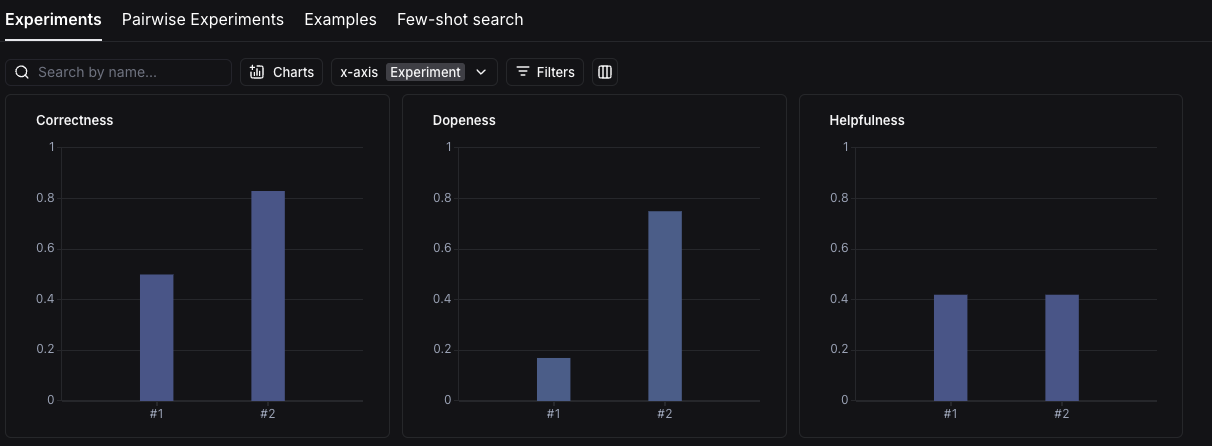